In [1]:
import copy
import numpy as np
import pandas as pd
import scipy.stats
import dftools
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.18/00


In [2]:
plt.style.use("cms")

In [3]:
_df_data = pd.read_hdf("data/fitinputs_v2.h5", "Data")
_df_mc = pd.read_hdf("data/fitinputs_v2.h5", "MC")
_df_mc_smooth = pd.read_hdf("data/fitinputs_v2.h5", "MCSmoothv2")
_df_mc_p4 = pd.read_hdf("data/fitinputs_v2.h5", "MCPoly4")
_df_mc_flat = pd.read_hdf("data/fitinputs_v2.h5", "MCFlat")

_df_data = _df_data.loc[~_df_data.index.duplicated(keep="first")]
_df_mc = _df_mc.loc[~_df_mc.index.duplicated(keep="first")]
_df_mc_smooth = _df_mc_smooth.loc[~_df_mc_smooth.index.duplicated(keep="first")]
_df_mc_p4 = _df_mc_p4.loc[~_df_mc_p4.index.duplicated(keep="first")]
_df_mc_flat = _df_mc_flat.loc[~_df_mc_flat.index.duplicated(keep="first")]

## Modify dataframes

Alter the dataframes, for example, to make or break correlations between systematic uncertainties, remove variations from particular sources, or switch to polyfit smoothing or a flat systematic

### Rename nuisances

In [4]:
region_mapping = {
    "Monojet": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "DoubleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig2MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
}

for region, mapping in region_mapping.items():
    selection = (_df_mc.index.get_level_values("variation")=="") & (_df_mc.index.get_level_values("region")==region)
    tdf = _df_mc.loc[selection,:]
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Up")) & (_df_mc.index.get_level_values("region")==region)
    tdf_up = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Up": v.format(region=region)+"Up" for k, v in mapping.items()},
    )
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Down")) & (_df_mc.index.get_level_values("region")==region)
    tdf_do = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Down": v.format(region=region)+"Down" for k, v in mapping.items()},
    )
    _df_mc = pd.concat([tdf, tdf_up, tdf_do, _df_mc.loc[_df_mc.index.get_level_values("region")!=region,:].copy()], axis=0, sort=False)

## Remove nuisances

In [5]:
_df_mc.loc[("Monojet", "ZJetsToNuNu"),:].index.get_level_values("variation").unique()

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Index(['', 'alphasUp', 'btagSFUp', 'd1kewUp', 'd1kqcdUp', 'd2kewwUp',
       'd2kewzUp', 'd2kqcdUp', 'd3kewwUp', 'd3kewzUp', 'd3kqcdUp', 'dkmixUp',
       'eleEnergyScaleUp', 'eleIdIsoTightUp', 'eleIdIsoVetoUp', 'eleRecoUp',
       'eleTrigUp', 'jerSFUp', 'jesTotalUp', 'lhePdfWeightUp',
       'lheScaleWeightUp', 'lumiUp', 'metTrig0MuSystUp',
       'metTrigReferenceTriggerSystUp', 'metTrigMonojetSystUp',
       'muonIdLooseStatUp', 'muonIdLooseSystUp', 'muonIdTightStatUp',
       'muonIdTightSystUp', 'muonIsoLooseStatUp', 'muonIsoLooseSystUp',
       'muonIsoTightStatUp', 'muonIsoTightSystUp', 'muonPtScaleUp',
       'muonTrigUp', 'photonEnergyScaleUp', 'photonIdLooseUp',
       'photonPixelSeedVetoUp', 'pileupUp', 'prefiringUp', 'tauIdTightUp',
       'tauIdVLooseUp', 'tauPtScaleUp', 'unclustUp', 'alphasDown',
       'btagSFDown', 'd1kewDown', 'd1kqcdDown', 'd2kewwDown', 'd2kewzDown',
       'd2kqcdDown', 'd3kewwDown', 'd3kewzDown', 'd3kqcdDown', 'dkmixDown',
       'eleEnergyScaleDo

In [6]:
region_process_variations = {
    ("Monojet", "ZJetsToNuNu"): ["lheScaleWeight", "eleTrig", "muonTrig"],
    ("Monojet", "WJetsToLNu"): ["lheScaleWeight", "eleTrig", "muonTrig"],
    ("Monojet", "QCD"): ["eleTrig", "muonTrig"],
    ("Monojet", "MinorBkgs"): ["eleTrig", "muonTrig"],
    ("SingleMuon", "WJetsToLNu"): ["lheScaleWeight", "muonTrig", "eleTrig"],
    ("SingleMuon", "QCD"): ["muonTrig", "eleTrig"],
    ("SingleMuon", "MinorBkgs"): ["muonTrig", "eleTrig"],
    ("SingleElectron", "WJetsToLNu"): ["lheScaleWeight", "muonTrig"],
    ("SingleElectron", "MinorBkgs"): ["muonTrig"],
    ("DoubleMuon", "DYJetsToLL"): ["lheScaleWeight", "muonTrig", "eleTrig"],
    ("DoubleMuon", "MinorBkgs"): ["muonTrig", "eleTrig"],
    ("DoubleElectron", "DYJetsToLL"): ["lheScaleWeight", "muonTrig"],
    ("DoubleElectron", "MinorBkgs"): ["muonTrig"],
}

drops = [
    (r, p, v+"Up")
    for (r, p), vs in region_process_variations.items()
    for v in vs
] + [
    (r, p, v+"Down")
    for (r, p), vs in region_process_variations.items()
    for v in vs
]
_df_mc = _df_mc.drop(drops, errors='ignore')

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


## Use gaussian filter smoothing

In [7]:
vjets = [
    "lhePdfWeight", "jesTotal", "jerSF", "unclust", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst",
    "muonIdTightStat", "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose", "btagSF",
]
minor_bkgs = [
    "lhePdfWeight", "lheScaleWeight", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat",
    "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose",
]
qcd = [
    "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat", "muonIsoLooseSyst",
    "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose",
]

region_process_variations = {
    ("Monojet", "ZJetsToNuNu"): vjets,
    ("Monojet", "WJetsToLNu"): vjets,
    ("Monojet", "QCD"): qcd,
    ("Monojet", "MinorBkgs"): minor_bkgs,
    ("SingleMuon", "WJetsToLNu"): vjets,
    ("SingleMuon", "MinorBkgs"): minor_bkgs,
    ("SingleMuon", "QCD"): qcd,
    ("SingleElectron", "WJetsToLNu"): vjets,
    ("SingleElectron", "MinorBkgs"): minor_bkgs,
    ("DoubleMuon", "DYJetsToLL"): vjets,
    ("DoubleMuon", "MinorBkgs"): minor_bkgs,
    ("DoubleElectron", "DYJetsToLL"): vjets,
    ("DoubleElectron", "MinorBkgs"): minor_bkgs,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_smooth.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


## Use polyfit smoothing

In [8]:
vjets = [
    "d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d3keww", "dkmix",
]

region_process_variations = {
    ("Monojet", "ZJetsToNuNu"): vjets,
    ("Monojet", "WJetsToLNu"): vjets,
    ("SingleMuon", "WJetsToLNu"): vjets,
    ("SingleElectron", "WJetsToLNu"): vjets,
    ("DoubleMuon", "DYJetsToLL"): vjets,
    ("DoubleElectron", "DYJetsToLL"): vjets,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_p4.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


## Use flat systematic


In [9]:
qcd = ["jesTotal", "jerSF", "unclust", "pileup", "eleReco", "btagSF"]
minors = ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight", "btagSF"]

process_variations = {
    ("Monojet", "QCD"): qcd,
    ("Monojet", "MinorBkgs"): minors,
    ("SingleMuon", "QCD"): qcd,
    ("SingleMuon", "MinorBkgs"): minors,
    ("SingleElectron", "MinorBkgs"): minors,
    ("DoubleMuon", "MinorBkgs"): minors,
    ("DoubleElectron", "MinorBkgs"): minors,
}

for (region, process), variations in process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            _df_mc.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ] = _df_mc_flat.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ]

## Symmetrize

In [10]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "tauIdTightUp"
tdf_do["variation"] = "tauIdTightDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightDown"),:] = tdf_do

In [11]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "unclustUp"
tdf_do["variation"] = "unclustDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustDown"),:] = tdf_do

In [12]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "jerSFUp"
tdf_do["variation"] = "jerSFDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFDown"),:] = tdf_do

In [13]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "jesTotalUp"
tdf_do["variation"] = "jesTotalDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"),:] = tdf_do

## Split JES uncertainties

In [14]:
bin_min = _df_data.index.get_level_values("bin_min").unique().values
bin_max = _df_data.index.get_level_values("bin_max").unique().values
bin_edge = np.array(list(bin_min) + [bin_max[-1]])
bin_edge

array([ 200.,  220.,  250.,  280.,  310.,  340.,  370.,  400.,  430.,
        470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,  840.,
        900.,  960., 1020., 1090., 1160., 1250., 1400., 1550.])

In [15]:
to_merge = []
#for region in ["SingleElectron", "DoubleElectron"]:
for region in ["Monojet", "SingleMuon", "DoubleMuon", "SingleElectron", "DoubleElectron"]:
    for variation in ["jesTotal", "jerSF", "unclust"]:
        for updown in ["Up", "Down"]:
            tmp = _df_mc.loc[(region, pd.IndexSlice[:], variation+updown),:]
            tmp = tmp.rename(index={variation+updown: variation+region+updown}, level="variation")
            to_merge.append(tmp)
_df_mc = pd.concat([_df_mc]+to_merge, axis=0, sort=True)

In [16]:
#for idx, bval in enumerate(bin_min):
#    nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""), :].reset_index("variation", drop=True)
#    var_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
#    var_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
#    
#    selection = nom.index.get_level_values("bin_min")==bval
#    var_up.loc[selection,:] = nom.loc[selection,:]
#    var_down.loc[selection,:] = nom.loc[selection,:]
#    
#    var_up["variation"] = "jesTotalB{}Up".format(idx)
#    var_down["variation"] = "jesTotalB{}Down".format(idx)
#    
#    order = ["region", "process", "variation", "bin_min", "bin_max"]
#    var_up = var_up.set_index("variation", append=True).reorder_levels(order).sort_index()
#    var_down = var_down.set_index("variation", append=True).reorder_levels(order).sort_index()
#    
#    _df_mc = pd.concat([_df_mc, var_down, var_up], axis=0, sort=True)
#    _df_mc.tail(5)

In [17]:
#nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""), :].reset_index("variation", drop=True)
#var_low_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
#var_low_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
#var_high_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
#var_high_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
#
#selection = nom.index.get_level_values("bin_min")>1000.
#var_low_up.loc[selection,:] = nom.loc[selection,:]
#var_low_down.loc[selection,:] = nom.loc[selection,:]
#
#var_high_up.loc[~selection,:] = nom.loc[~selection,:]
#var_high_down.loc[~selection,:] = nom.loc[~selection,:]
#
#var_low_up["variation"] = "jesTotalLowUp"
#var_low_down["variation"] = "jesTotalLowDown"
#var_high_up["variation"] = "jesTotalHighUp"
#var_high_down["variation"] = "jesTotalHighDown"
#
#order = ["region", "process", "variation", "bin_min", "bin_max"]
#var_low_up = var_low_up.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_low_down = var_low_down.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_high_up = var_high_up.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_high_down = var_high_down.set_index("variation", append=True).reorder_levels(order).sort_index()
#
#_df_mc = pd.concat([_df_mc, var_low_down, var_low_up, var_high_down, var_high_up], axis=0, sort=True)
#_df_mc.tail(5)

In [18]:
df_data = _df_data.unstack().unstack().loc[[
    ("MET", "Monojet"),
    ("MET", "SingleMuon"),
    ("MET", "DoubleMuon"),
    ("SingleElectron", "SingleElectron"),
    ("SingleElectron", "DoubleElectron"),
]].stack().stack().reset_index("trigger").drop("trigger", axis=1)
df_data.head(5)

count     sum_w    sum_ww
region  bin_min bin_max                              
Monojet 200.0   220.0    100530.0  100530.0  100530.0
        220.0   250.0    142330.0  142330.0  142330.0
        250.0   280.0    102427.0  102427.0  102427.0
        280.0   310.0     66110.0   66110.0   66110.0
        310.0   340.0     41367.0   41367.0   41367.0

In [19]:
df_mc = _df_mc.copy(deep=True)
df_mc.head(30)

sum_w       sum_ww
region     process    variation bin_min bin_max                          
DoubleMuon DYJetsToLL           200.0   220.0    3236.184095   768.120728
                                220.0   250.0    5233.734667  1111.948738
                                250.0   280.0    4321.105366   650.961742
                                280.0   310.0    3081.230471   244.541571
                                310.0   340.0    2132.301105    94.152928
                                340.0   370.0    1475.857454    53.926664
                                370.0   400.0     992.210351    37.620910
                                400.0   430.0     663.230560    28.511451
                                430.0   470.0     560.985071    27.581216
                                470.0   510.0     344.081583    17.901991
                                510.0   550.0     224.266128    11.301424
                                550.0   590.0     143.025033     7.196915
                                590.0   640.0     115.355197     5.262883
                                640.0   690.0      68.455105     2.213242
                                690.0   740.0      40.639383     0.601003
                                740.0   790.0      25.331025     0.164831
                                790.0   840.0      17.234054     0.077535
                                840.0   900.0      12.872755     0.056071
                                900.0   960.0       7.699648     0.031386
                                960.0   1020.0      4.818195     0.020460
                                1020.0  1090.0      3.480534     0.013794
                                1090.0  1160.0      2.135376     0.008295
                                1160.0  1250.0      1.498013     0.005933
                                1250.0  1400.0      1.120919     0.004172
                                1400.0  1550.0      0.683578     0.002718
           MinorBkgs            200.0   220.0     183.419165   171.793242
                                220.0   250.0     317.971478   352.310804
                                250.0   280.0     221.964530   325.758244
                                280.0   310.0     215.624429   236.232757
                                310.0   340.0     168.794255   147.271603

## Run fits

In [20]:
bin_min = df_data.index.get_level_values("bin_min").unique().values
bin_max = df_data.index.get_level_values("bin_max").unique().values
bin_edge = np.array(list(bin_min) + [bin_max[-1]])
bin_edge

array([ 200.,  220.,  250.,  280.,  310.,  340.,  370.,  400.,  430.,
        470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,  840.,
        900.,  960., 1020., 1090., 1160., 1250., 1400., 1550.])

In [21]:
df_mc.index.get_level_values("variation").unique()

Index(['', 'alphasUp', 'btagSFUp', 'd1kewUp', 'd1kqcdUp', 'd2kewwUp',
       'd2kewzUp', 'd2kqcdUp', 'd3kewwUp', 'd3kewzUp',
       ...
       'jerSFSingleElectronUp', 'jerSFSingleElectronDown',
       'unclustSingleElectronUp', 'unclustSingleElectronDown',
       'jesTotalDoubleElectronUp', 'jesTotalDoubleElectronDown',
       'jerSFDoubleElectronUp', 'jerSFDoubleElectronDown',
       'unclustDoubleElectronUp', 'unclustDoubleElectronDown'],
      dtype='object', name='variation', length=129)

In [22]:
df_kzkg = pd.read_hdf("data/gstar_prediction.h5", "GStarPredictions").set_index("parameter").stack()
df_kzkg.index.names = ["parameter", "variation"]
value = df_kzkg.loc[(pd.IndexSlice[:],"value")]
relvals = df_kzkg.divide(value)-1.

selection = df_kzkg.index.get_level_values("variation")!="value"
df_kzkg.loc[selection] = relvals.loc[selection]
df_kzkg

parameter  variation         
kz         value                 1.016459
           statUp                0.000825
           statDown             -0.000824
           genIdReweightUp       0.014404
           genIdReweightDown    -0.014404
           lhePdfWeightUp        0.022977
           lhePdfWeightDown     -0.022977
           lheScaleWeightUp      0.000000
           lheScaleWeightDown    0.000000
kg         value                 0.015040
           statUp                0.001487
           statDown             -0.001485
           genIdReweightUp       0.134813
           genIdReweightDown    -0.134813
           lhePdfWeightUp        0.024335
           lhePdfWeightDown     -0.024335
           lheScaleWeightUp      0.000000
           lheScaleWeightDown    0.000000
dtype: float64

In [23]:
bins = (bin_min, bin_max)

regions = {
    "Monojet":        ["ZJetsToNuNu", "WJetsToLNu", "QCD", "MinorBkgs"],
    "SingleMuon":     ["WJetsToLNu", "MinorBkgs", "QCD"],
    "SingleElectron": ["WJetsToLNu", "MinorBkgs"],
    "DoubleMuon":     ["DYJetsToLL", "MinorBkgs"],
    "DoubleElectron": ["DYJetsToLL", "MinorBkgs"],
}

kz = (
    "p['kz']*"+
    "np.power("+
        "(1 + (p['kzStat']>=0)*p['kzStat_valUp'] + (p['kzStat']<0)*p['kzStat_valDown']),"+
        "p['kzStat'],"+
    ")*np.power("+
        "(1 + (p['lhePdfWeight']>=0)*p['kzPdf_valUp'] + (p['lhePdfWeight']<0)*p['kzPdf_valDown']),"+
        "p['lhePdfWeight'],"+
    ")*np.power("+
        "(1 + (p['lheScaleWeight']>=0)*p['kzScale_valUp'] + (p['lheScaleWeight']<0)*p['kzScale_valDown']),"+
        "p['lheScaleWeight'],"+
    ")*np.power("+
        "(1 + (p['genIdReweight']>=0)*p['kzGenIdReweight_valUp'] + (p['genIdReweight']<0)*p['kzGenIdReweight_valDown']),"+
        "p['genIdReweight'],"+
    ")"
)
kg = (
    "p['kg']*"+
    "np.power("+
        "(1 + (p['kgStat']>=0)*p['kgStat_valUp'] + (p['kgStat']<0)*p['kgStat_valDown']),"+
        "p['kgStat'],"+
    ")*np.power("+
        "(1 + (p['lhePdfWeight']>=0)*p['kgPdf_valUp'] + (p['lhePdfWeight']<0)*p['kgPdf_valDown']),"+
        "p['lhePdfWeight'],"+
    ")*np.power("+
        "(1 + (p['lheScaleWeight']>=0)*p['kgScale_valUp'] + (p['lheScaleWeight']<0)*p['kgScale_valDown']),"+
        "p['lheScaleWeight'],"+
    ")*np.power("+
        "(1 + (p['genIdReweight']>=0)*p['kgGenIdReweight_valUp'] + (p['genIdReweight']<0)*p['kgGenIdReweight_valDown']),"+
        "p['genIdReweight'],"+
    ")"
)

kzkg_params = [
    {"name": "kz",                      "value": df_kzkg.loc[("kz", "value")],              "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzStat_valUp",            "value": df_kzkg.loc[("kz", "statUp")],             "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzStat_valDown",          "value": df_kzkg.loc[("kz", "statDown")],           "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzPdf_valUp",             "value": df_kzkg.loc[("kz", "lhePdfWeightUp")],     "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzPdf_valDown",           "value": df_kzkg.loc[("kz", "lhePdfWeightDown")],   "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzScale_valUp",           "value": df_kzkg.loc[("kz", "lheScaleWeightUp")],   "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzScale_valDown",         "value": df_kzkg.loc[("kz", "lheScaleWeightDown")], "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzGenIdReweight_valUp",   "value": df_kzkg.loc[("kz", "genIdReweightUp")],    "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzGenIdReweight_valDown", "value": df_kzkg.loc[("kz", "genIdReweightDown")],  "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kg",                      "value": df_kzkg.loc[("kg", "value")],              "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgStat_valUp",            "value": df_kzkg.loc[("kg", "statUp")],             "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgStat_valDown",          "value": df_kzkg.loc[("kg", "statDown")],           "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgPdf_valUp",             "value": df_kzkg.loc[("kg", "lhePdfWeightUp")],     "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgPdf_valDown",           "value": df_kzkg.loc[("kg", "lhePdfWeightDown")],   "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgScale_valUp",           "value": df_kzkg.loc[("kg", "lheScaleWeightUp")],   "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgScale_valDown",         "value": df_kzkg.loc[("kg", "lheScaleWeightDown")], "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgGenIdReweight_valUp",   "value": df_kzkg.loc[("kg", "genIdReweightUp")],    "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgGenIdReweight_valDown", "value": df_kzkg.loc[("kg", "genIdReweightDown")],  "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzStat",        "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
    {"name": "kgStat",        "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
    {"name": "genIdReweight", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
]

config ={
    "regions": regions,
    "parameters": [
        {"name": "rZJets",       "value": 1., "limit": (None, None), "fixed": False, "constraint": "free"},
        {"name": "rZJetsToNuNu", "value": 1., "limit": (None, None), "fixed": False, "constraint": "free"},
        {"name": "rWJetsToLNu",  "value": 1., "limit": (None, None), "fixed": False, "constraint": "free"},
    ] + kzkg_params + [
        {"name": "metTrig0MuSyst",              "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig1MuSyst",              "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig2MuSyst",              "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrigReferenceTriggerSyst", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "metTrig{}Syst".format(r), "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"}
        for r in ["Monojet", "SingleMuon", "DoubleMuon"] if r in regions.keys()
    ] + [
        {"name": "muonIdLooseSyst",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdLooseStat",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightSyst",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightStat",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseSyst", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseStat", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightSyst", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightStat", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonTrig",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonPtScale",      "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "eleIdIsoTight",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "eleIdIsoVeto",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "eleReco",        "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "eleTrig",        "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "eleEnergyScale", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "photonIdLoose",       "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "photonPixelSeedVeto", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "photonEnergyScale",   "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "tauIdVLoose", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "tauIdTight",  "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "tauPtScale",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "btagSF",      "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "jesTotal",    "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "jerSF",       "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "unclust",     "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "jesTotal{}".format(region), "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"}
        for r in ["Monojet", "SingleMuon", "DoubleMuon", "SingleElectron", "DoubleElectron"]
    ] + [
        {"name": "lumi",      "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "pileup",    "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "prefiring", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        
        {"name": "d1kqcd",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kqcd",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kqcd",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d1kew",          "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kewz",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d2keww",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kewz",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "d3keww",         "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "dkmix",          "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        #{"name": "alphas",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "lhePdfWeight",   "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
        {"name": "lheScaleWeight", "value": 0., "limit": (None, None), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "{}_mcstat_bin{}".format(r, idx), "value": 0., "limit": (None, None), "fixed": False, "constraint": "gamma"}
        for r in regions.keys()
        for idx in range(len(bin_min))
    ],
    "scale_functions": {
        ("Monojet",        "ZJetsToNuNu"):  "x, w, p: p['rZJets']*p['rZJetsToNuNu']",
        ("Monojet",        "WJetsToLNu"):   "x, w, p: p['rWJetsToLNu']",
        ("SingleMuon",     "WJetsToLNu"):   "x, w, p: p['rWJetsToLNu']",
        ("SingleElectron", "WJetsToLNu"):   "x, w, p: p['rWJetsToLNu']",
        ("DoubleMuon",     "DYJetsToLL"):   "x, w, p: ({kz})*p['rZJets'] + (1-({kz})-({kg}))*np.sqrt(p['rZJets']) + ({kg})".format(kz=kz, kg=kg),
        ("DoubleElectron", "DYJetsToLL"):   "x, w, p: ({kz})*p['rZJets'] + (1-({kz})-({kg}))*np.sqrt(p['rZJets']) + ({kg})".format(kz=kz, kg=kg),
    }
}


## Asimov fit

In [24]:
#model = dftools.fitting.NLLModel2(df_data, df_mc, config, same_bin_widths=True)
#minimizer = model.fit(asimov=True, migrad=False, minos=False)
#minimizer.migrad(ncall=100_000)

In [25]:
#results = dftools.fitting.run_impacts(
#    minimizer.parameters, "rWJetsToLNu",
#    nll_args=(df_data, df_mc, bins, config),
#    nll_kwargs=dict(same_bin_widths=True),
#    fit_kwargs=dict(asimov=True, migrad=False, minos=False),
#    migrad_kwargs=dict(ncall=100_000),
#    pysge_function="sge_submit",
#    pysge_args=("zfit", "_ccsp_temp"),
#    pysge_kwargs=dict(options="-q hep.q", dill_kw={"recurse": False}),
#    params_guess=list(minimizer.args),
#)

In [26]:
#pd.set_option('display.float_format', lambda x: '%.5f' % x)
#pd.set_option('display.max_rows', None)
#df = pd.DataFrame(results)
#df["envelope"] = np.abs(df[["poi_paramup", "poi_paramdown"]]).max(axis=1)
#df = df.sort_values("envelope", ascending=False).reset_index(drop=True).set_index(["param", "poi"])
#df.loc[~df.index.get_level_values("param").str.contains("mcstat"),:]

## Observed fit

In [ ]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
minimizer = model.fit(migrad=False, minos=False)

In [ ]:
%time minimizer.migrad(ncall=100_000)

In [ ]:
#results_minos = dftools.fitting.run_minos(
#    [p for p in minimizer.parameters if not minimizer.fixed[p]],
#    nll_args=(df_data, df_mc, config),
#    nll_kwargs=dict(same_bin_widths=True),
#    migrad_kwargs=dict(ncall=100_000),
#    pysge_function="sge_submit",
#    pysge_args=("zfit", "_ccsp_temp"),
#    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G", dill_kw={"recurse": False}),
#    params_guess=list(minimizer.args),
#)

In [ ]:
results_impacts = dftools.fitting.run_impacts(
    [p for p in minimizer.parameters if not minimizer.fixed[p] and "mcstat" not in p],
    "rZJetsToNuNu",
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G", dill_kw={"recurse": False}),
    params_guess=list(minimizer.args),
)

In [ ]:
pd.set_option('display.max_rows', None)
pd.DataFrame(results_impacts)

In [ ]:
df = pd.DataFrame(results_impacts)
#print(df)
df["envelope"] = np.abs(df[["poi_paramup", "poi_paramdown"]]).max(axis=1)
df = df.sort_values("envelope").reset_index(drop=True).set_index(["param", "poi"])
selection = (
    #~df.index.get_level_values("param").str.contains("mcstat")
    df.index.get_level_values("param").isin([
        "rZJetsToNuNu",
        "jesTotalMonojet", "jesTotalSingleMuon", "jesTotalSingleElectron", "jesTotalDoubleMuon", "jesTotalDoubleElectron",
        "jesTotalElectron",
        "unclust", "muonIdTightStat", "muonIdTightSyst", "jesTotal", "jerSF", "eleTrig", "metTrigDoubleMuonSyst", "metTrig2MuSyst", "tauIdVLoose", "pileup",
        "d1kqcd", "metTrigSingleMuonSyst", "metTrigMonojetSyst", "eleReco", "prefiring", "muonIsoTightStat", "metTrig1MuSyst", "lhePdfWeight", "d3kqcd",
        "d2kqcd", "d3kewz", "eleIdIsoTight", "dkmix", "lumi", "d2keww", "metTrigReferenceTriggerSyst", "muonIsoTightSyst", "d2kewz", "d1kew", "genIdReweight",
        "d3keww", "btagSF", "lheScaleWeight", "metTrig0MuSyst", "eleIdIsoVeto", "kzStat", "muonIdVetoStat", "kgStat", "tauIdTight", "muonIdLooseSyst",
        "photonPixelSeedVeto", "muonIsoLooseStat", "photonIdLoose", "muonIsoLooseSyst",
    ])
)
tdf = df.loc[selection,:].drop("envelope", axis=1).iloc[-20:]
#print(tdf)
#tdf.loc[("rZJetsToNuNu", "rZJets"),"param_value"] = np.nan
tdf.loc[("rZJetsToNuNu", "rZJetsToNuNu"),"param_value"] = np.nan
conv = dftools.draw.nuisance_names
conv["rZJetsToNuNu"] = r'$r_{\mathrm{inv}}$'
conv["metTrigMonojetSyst"] = r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger ($p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}$)'
fig, ax = dftools.draw.draw_impacts(
    tdf, converter=conv
)

ax[0].text(
    0, 1, r'$\mathbf{CMS}$', ha='left', va='bottom',
    transform=ax[0].transAxes,
)
ax[1].text(
    1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)', ha='right', va='bottom',
    transform=ax[1].transAxes,
)
ax[1].set_xlabel(r'$\Delta \hat{r}_{\mathrm{inv}}$')
ax[1].set_xlim(-0.035, 0.035)
ax[1].legend(loc=4, fancybox=True, edgecolor="gray")
fig.set_size_inches(3,4.5)
fig.align_labels(ax)
#fig.savefig("plots/impacts.pdf", format='pdf', bbox_inches='tight')

/vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/externals/dftools/dftools/fitting.py:1: RuntimeWarning: invalid value encountered in sqrt
  import pysge


RuntimeError: NaN in prediction(DoubleMuon): [[           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan]
 [1.81290458e+02 3.16907742e+02 2.20338899e+02 2.13090778e+02
  1.66397333e+02 1.15411025e+02 7.69190196e+01 6.50509550e+01
  6.16760246e+01 3.99787073e+01 2.35549119e+01 1.54072838e+01
  1.91180860e+01 9.32560017e+00 4.33031039e+00 6.16140296e+00
  2.39526377e+00 2.80686775e+00 1.60486549e+00 1.10782847e+00
  8.05572127e-01 7.22744302e-01 1.25654460e-01 2.19943868e-07
  9.13861202e-02]]

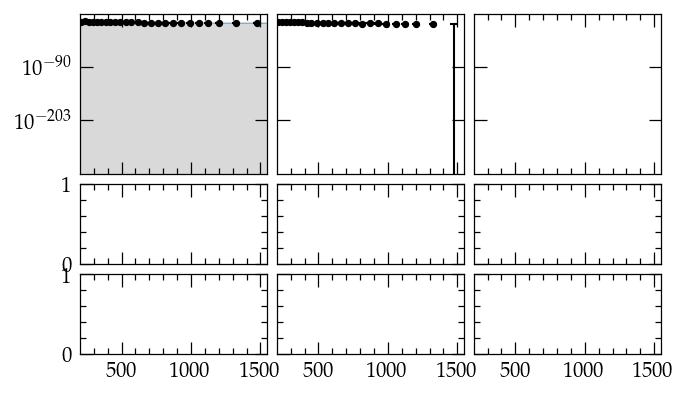

In [38]:
fig, ax = plt.subplots(
    figsize=(5, 3), dpi=150,
    nrows=3, ncols=3,
    sharex='col', sharey='row',
    gridspec_kw={
        "height_ratios": (2,1,1),
        "hspace": 0.1, "wspace": 0.05,
    },
)
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(model.bins["Monojet"][0][0], model.bins["Monojet"][1][-1])
ax[0,1].set_xlim(model.bins["Monojet"][0][0], model.bins["Monojet"][1][-1])
ax[0,2].set_xlim(model.bins["Monojet"][0][0], model.bins["Monojet"][1][-1])

model.draw_data("Monojet", ax[0,0], label="Data")
model.draw_prediction_total("Monojet", ax[0,0])
model.draw_prediction_procs("Monojet", ax[0,0])
#model.draw_data("Monojet", ax[1,0], ratio=True)
#model.draw_prediction_total("Monojet", ax[1,0], ratio=True, hkwargs={"label": "SM postfit"})
#model.draw_prediction_total("Monojet", ax[1,0], ratio=True, prefit=True, band=False, hkwargs={"label": "SM prefit"})
#model.draw_data("Monojet", ax[2,0], pull=True)

model.draw_data("DoubleMuon", ax[0,1])
model.draw_prediction_total("DoubleMuon", ax[0,1])
model.draw_prediction_procs("DoubleMuon", ax[0,1])
#model.draw_data("DoubleMuon", ax[1,1], ratio=True)
#model.draw_prediction_total("DoubleMuon", ax[1,1], ratio=True)
#model.draw_prediction_total("DoubleMuon", ax[1,1], ratio=True, prefit=True, band=False)
#model.draw_data("DoubleMuon", ax[2,1], pull=True)

model.draw_data("DoubleElectron", ax[0,2])
model.draw_prediction_total("DoubleElectron", ax[0,2])
model.draw_prediction_procs("DoubleElectron", ax[0,2])
#model.draw_data("DoubleElectron", ax[1,2], ratio=True)
#model.draw_prediction_total("DoubleElectron", ax[1,2], ratio=True)
#model.draw_prediction_total("DoubleElectron", ax[1,2], ratio=True, prefit=True, band=False)
#model.draw_data("DoubleElectron", ax[2,2], pull=True)

#ax[0,0].set_ylim(1, 1e5)
#ax[1,0].set_ylim(0.6, 1.4)
#ax[2,0].set_ylim(-2, 2)
#
#ax[0,1].set_ylim(1, 1e5)
#ax[1,1].set_ylim(0.6, 1.4)
#ax[2,1].set_ylim(-2, 2)
#
#ax[0,2].set_ylim(1, 1e5)
#ax[1,2].set_ylim(0.6, 1.4)
#ax[2,2].set_ylim(-2, 2)

ax[2,0].axhline(0., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,0].axhline(1., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,0].axhline(-1., lw=1, ls='--', color='gray', alpha=0.6)

ax[2,1].axhline(0., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,1].axhline(1., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,1].axhline(-1., lw=1, ls='--', color='gray', alpha=0.6)

ax[2,2].axhline(0., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,2].axhline(1., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,2].axhline(-1., lw=1, ls='--', color='gray', alpha=0.6)

ax[0,0].set_ylabel('Events')
ax[1,0].set_ylabel('Ratio')
ax[2,0].set_ylabel('Residuals')
#ax[2,0].set_xlabel('$\mathcal{U}$ (GeV)')
ax[2,1].set_xlabel('$\mathcal{U}$ (GeV)')
#ax[2,2].set_xlabel('$\mathcal{U}$ (GeV)')

h1, l1 = ax[0,0].get_legend_handles_labels()
h2, l2 = ax[1,0].get_legend_handles_labels()
ax[0,2].legend(
    h1[::-1]+h2, l1[::-1]+l2,
    loc=2, bbox_to_anchor=(1,1),
    fancybox=True, edgecolor="#d9d9d9",
    labelspacing=0.1, borderpad=0.2,
)

ax[0,0].text(0.9, 0.9, r'$p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}$', ha='right', va='top', transform=ax[0,0].transAxes)
ax[0,1].text(0.9, 0.9, r'$\mu\mu+\mathrm{jets}$', ha='right', va='top', transform=ax[0,1].transAxes)
ax[0,2].text(0.9, 0.9, r'$ee+\mathrm{jets}$', ha='right', va='top', transform=ax[0,2].transAxes)

ax[0,0].text(0, 1, r'$\mathbf{CMS}$', ha='left', va='bottom', transform=ax[0,0].transAxes)
ax[0,2].text(1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)', ha='right', va='bottom', transform=ax[0,2].transAxes)
fig.align_labels(ax)
fig.savefig("plots/postfit_sr.pdf", format="pdf", bbox_inches='tight')
pass

## View parameter effects

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


bin_min  bin_max
200.0    220.0       90914.686916
220.0    250.0      128858.170150
250.0    280.0       92959.765182
280.0    310.0       60691.990887
310.0    340.0       38485.805118
340.0    370.0       24755.041746
370.0    400.0       15943.425216
400.0    430.0       10329.306014
430.0    470.0        8564.237517
470.0    510.0        5301.814384
510.0    550.0        3261.192442
550.0    590.0        2118.528731
590.0    640.0        1604.974010
640.0    690.0         942.380207
690.0    740.0         579.742389
740.0    790.0         380.724747
790.0    840.0         256.022952
840.0    900.0         184.671488
900.0    960.0         117.765353
960.0    1020.0         75.288828
1020.0   1090.0         55.630999
1090.0   1160.0         35.668521
1160.0   1250.0         22.809331
1250.0   1400.0         19.934594
1400.0   1550.0         14.323640
Name: prediction, dtype: float64


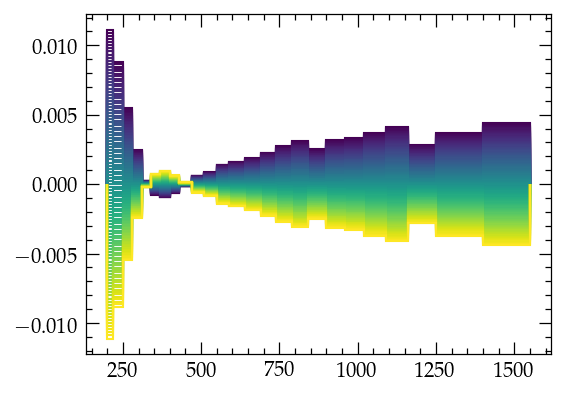

In [39]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
parameters = model.parameters

region = "Monojet"
#proc = "WJetsToLnu"
nuis = "unclust"

nom = model.predictions(region)["prediction"]
print(nom)
binmin, binmax = model.bins[region]

fig, ax = plt.subplots()

ndiv = 100
cmap = plt.get_cmap('viridis', ndiv+1)

for idx, theta in enumerate(np.linspace(-1., 1., 101)):
    parameters[nuis] = theta
    model.set_parameters(parameters)
    vari = model.predictions(region)["prediction"]

    ax.hist(
        binmin, bins=list(binmin)+[binmax[-1]], weights=vari/nom-1,
        histtype='step', color=cmap(idx),
    )

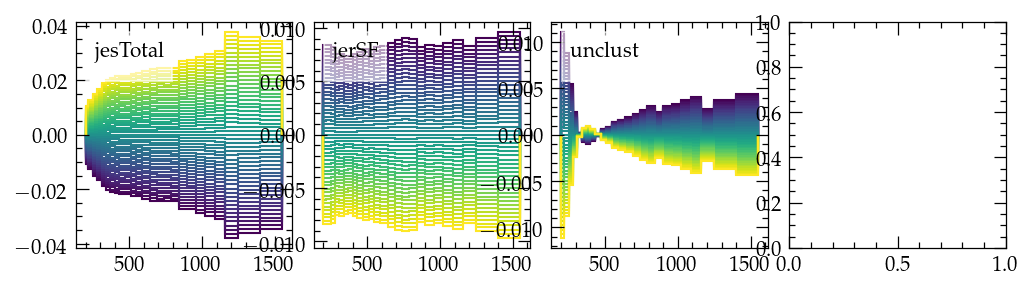

In [40]:
parameters = [
    #'metTrig1MuSyst', 'metTrigReferenceTriggerSyst', 'muonIdLooseSyst', 'muonIdLooseStat', 'muonIdTightSyst', 'muonIdTightStat', 'muonIsoLooseSyst', 'muonIsoLooseStat', 'muonIsoTightSyst', 'muonIsoTightStat',
    #'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig', 'photonIdLoose', 'photonPixelSeedVeto', 'tauIdVLoose', 'tauIdTight', 'btagSF', 'jesTotal', 'jerSF', 'unclust', 'lumi', 'pileup', 'prefiring', 'd1kqcd',
    #'d2kqcd', 'd3kqcd', 'd1kew', 'd2kewz', 'd2keww', 'd3kewz', 'd3keww', 'dkmix', 'alphas', 'lhePdfWeight', 'lheScaleWeight',
    "jesTotal", "jerSF", "unclust",
]
region = "Monojet"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]
pred_nom = model.predictions(region)["prediction"].values

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(parameters)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, param in enumerate(parameters):
    model.set_parameters(mod_params)
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[param] = theta
        model.set_parameters(tparams)
        pred = model.predictions(region)["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(parameters)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/pred_nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=param)


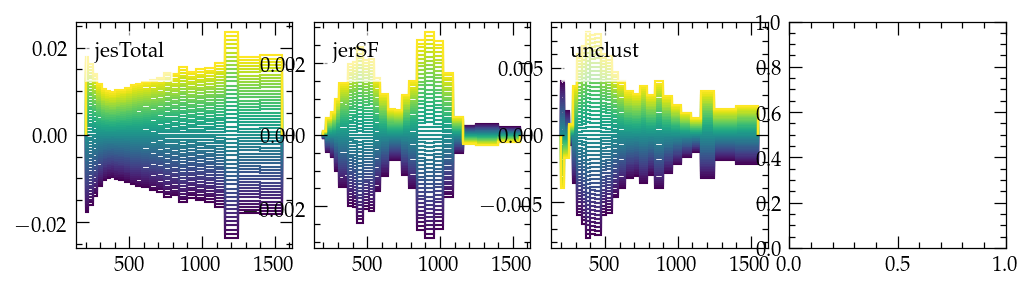

In [41]:
parameters = [
    #'metTrig1MuSyst', 'metTrigReferenceTriggerSyst', 'muonIdLooseSyst', 'muonIdLooseStat', 'muonIdTightSyst', 'muonIdTightStat', 'muonIsoLooseSyst', 'muonIsoLooseStat', 'muonIsoTightSyst', 'muonIsoTightStat',
    #'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig', 'photonIdLoose', 'photonPixelSeedVeto', 'tauIdVLoose', 'tauIdTight', 'btagSF', 'jesTotal', 'jerSF', 'unclust', 'lumi', 'pileup', 'prefiring', 'd1kqcd',
    #'d2kqcd', 'd3kqcd', 'd1kew', 'd2kewz', 'd2keww', 'd3kewz', 'd3keww', 'dkmix', 'alphas', 'lhePdfWeight', 'lheScaleWeight',
    "jesTotal", "jerSF", "unclust",
]
region = "SingleMuon"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]
pred_nom = model.predictions(region)["prediction"].values

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(parameters)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, param in enumerate(parameters):
    model.set_parameters(mod_params)
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[param] = theta
        model.set_parameters(tparams)
        pred = model.predictions(region)["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(parameters)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/pred_nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=param)


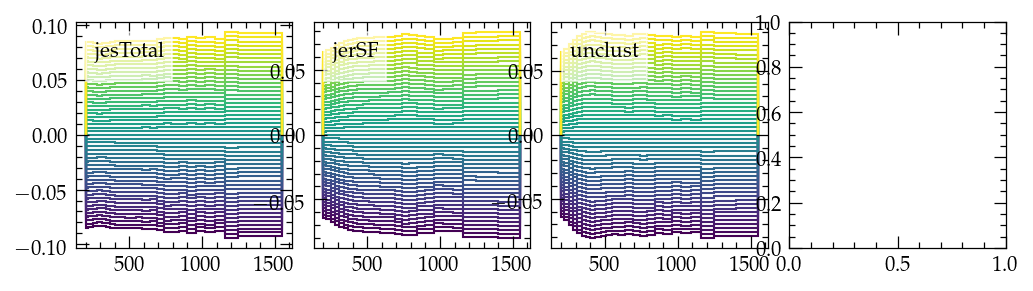

In [42]:
parameters = [
    #'metTrig1MuSyst', 'metTrigReferenceTriggerSyst', 'muonIdLooseSyst', 'muonIdLooseStat', 'muonIdTightSyst', 'muonIdTightStat', 'muonIsoLooseSyst', 'muonIsoLooseStat', 'muonIsoTightSyst', 'muonIsoTightStat',
    #'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig', 'photonIdLoose', 'photonPixelSeedVeto', 'tauIdVLoose', 'tauIdTight', 'btagSF', 'jesTotal', 'jerSF', 'unclust', 'lumi', 'pileup', 'prefiring', 'd1kqcd',
    #'d2kqcd', 'd3kqcd', 'd1kew', 'd2kewz', 'd2keww', 'd3kewz', 'd3keww', 'dkmix', 'alphas', 'lhePdfWeight', 'lheScaleWeight',
    "jesTotal", "jerSF", "unclust",
]
region = "SingleElectron"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]
pred_nom = model.predictions(region)["prediction"].values

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(parameters)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, param in enumerate(parameters):
    model.set_parameters(mod_params)
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[param] = theta
        model.set_parameters(tparams)
        pred = model.predictions(region)["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(parameters)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/pred_nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=param)


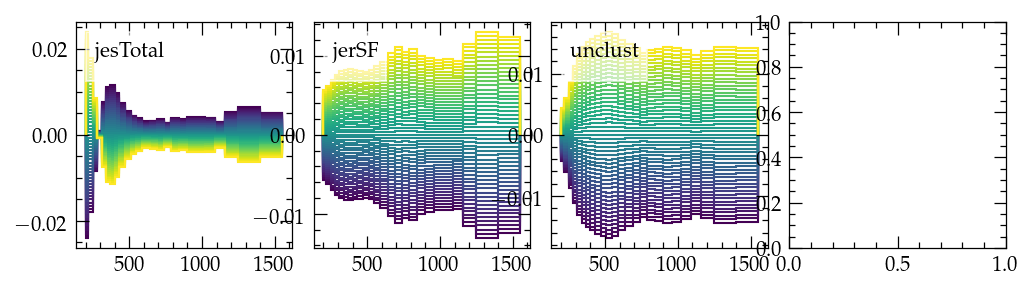

In [43]:
parameters = [
    #'metTrig1MuSyst', 'metTrigReferenceTriggerSyst', 'muonIdLooseSyst', 'muonIdLooseStat', 'muonIdTightSyst', 'muonIdTightStat', 'muonIsoLooseSyst', 'muonIsoLooseStat', 'muonIsoTightSyst', 'muonIsoTightStat',
    #'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig', 'photonIdLoose', 'photonPixelSeedVeto', 'tauIdVLoose', 'tauIdTight', 'btagSF', 'jesTotal', 'jerSF', 'unclust', 'lumi', 'pileup', 'prefiring', 'd1kqcd',
    #'d2kqcd', 'd3kqcd', 'd1kew', 'd2kewz', 'd2keww', 'd3kewz', 'd3keww', 'dkmix', 'alphas', 'lhePdfWeight', 'lheScaleWeight',
    "jesTotal", "jerSF", "unclust",
]
region = "DoubleMuon"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]
pred_nom = model.predictions(region)["prediction"].values

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(parameters)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, param in enumerate(parameters):
    model.set_parameters(mod_params)
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[param] = theta
        model.set_parameters(tparams)
        pred = model.predictions(region)["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(parameters)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/pred_nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=param)


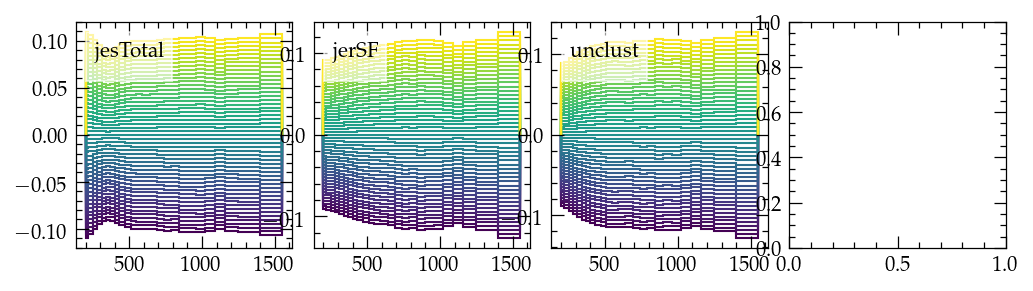

In [44]:
parameters = [
    #'metTrig1MuSyst', 'metTrigReferenceTriggerSyst', 'muonIdLooseSyst', 'muonIdLooseStat', 'muonIdTightSyst', 'muonIdTightStat', 'muonIsoLooseSyst', 'muonIsoLooseStat', 'muonIsoTightSyst', 'muonIsoTightStat',
    #'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig', 'photonIdLoose', 'photonPixelSeedVeto', 'tauIdVLoose', 'tauIdTight', 'btagSF', 'jesTotal', 'jerSF', 'unclust', 'lumi', 'pileup', 'prefiring', 'd1kqcd',
    #'d2kqcd', 'd3kqcd', 'd1kew', 'd2kewz', 'd2keww', 'd3kewz', 'd3keww', 'dkmix', 'alphas', 'lhePdfWeight', 'lheScaleWeight',
    "jesTotal", "jerSF", "unclust",
]
region = "DoubleElectron"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]
pred_nom = model.predictions(region)["prediction"].values

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(parameters)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, param in enumerate(parameters):
    model.set_parameters(mod_params)
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[param] = theta
        model.set_parameters(tparams)
        pred = model.predictions(region)["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(parameters)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/pred_nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=param)


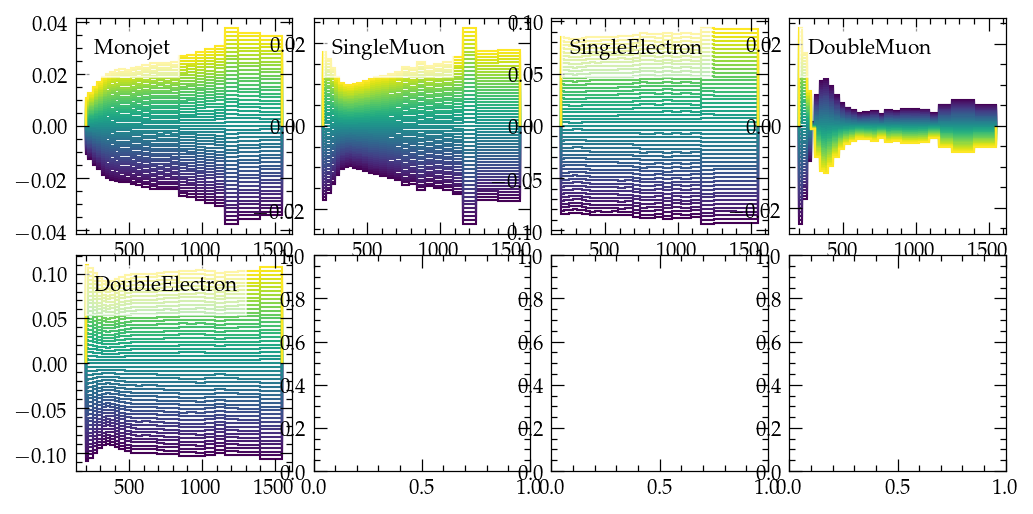

In [45]:
regions = ["Monojet", "SingleMuon", "SingleElectron", "DoubleMuon", "DoubleElectron"]
nuisance = "jesTotal"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(regions)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, region in enumerate(regions):
    model.set_parameters(mod_params)
    nom = model.predictions(region)["prediction"].values
    
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[nuisance] = theta
        model.set_parameters(tparams)
        pred = model.predictions(region)["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(regions)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=region)


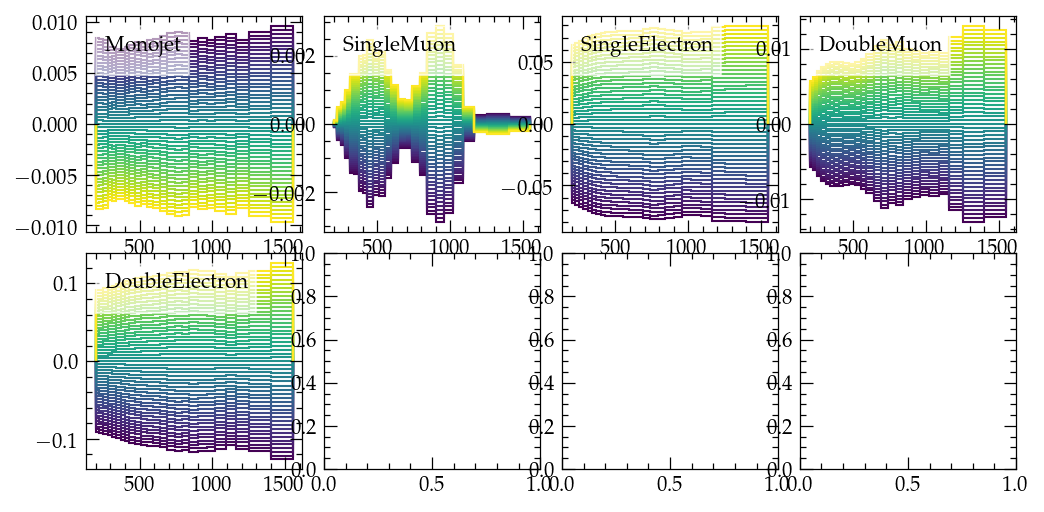

In [47]:
regions = ["Monojet", "SingleMuon", "SingleElectron", "DoubleMuon", "DoubleElectron"]
nuisance = "jerSF"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(regions)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, region in enumerate(regions):
    model.set_parameters(mod_params)
    nom = model.predictions(region)["prediction"].values
    
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[nuisance] = theta
        model.set_parameters(tparams)
        pred = model.predictions(region)["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(regions)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=region)


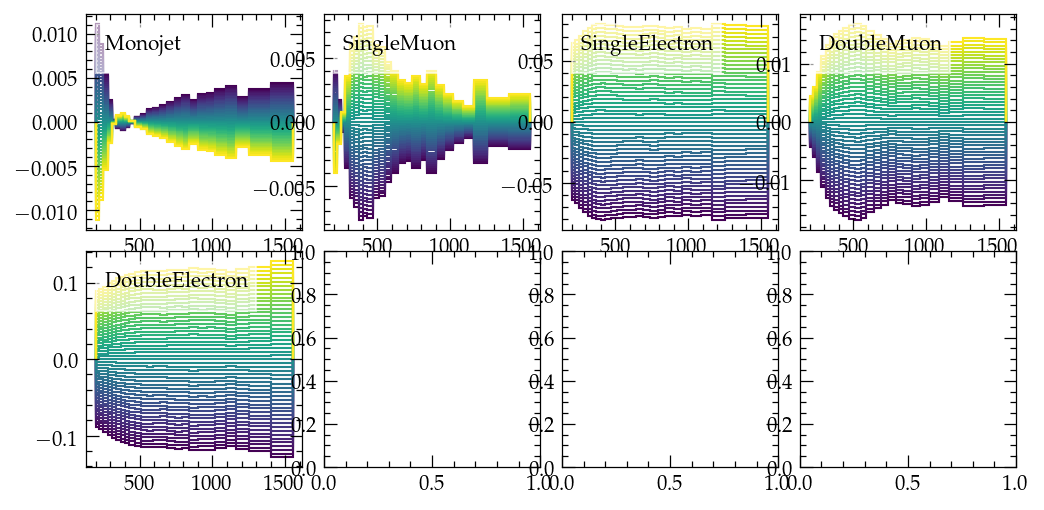

In [48]:
regions = ["Monojet", "SingleMuon", "SingleElectron", "DoubleMuon", "DoubleElectron"]
nuisance = "unclust"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(regions)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, region in enumerate(regions):
    model.set_parameters(mod_params)
    nom = model.predictions(region)["prediction"].values
    
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[nuisance] = theta
        model.set_parameters(tparams)
        pred = model.predictions(region)["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(regions)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=region)


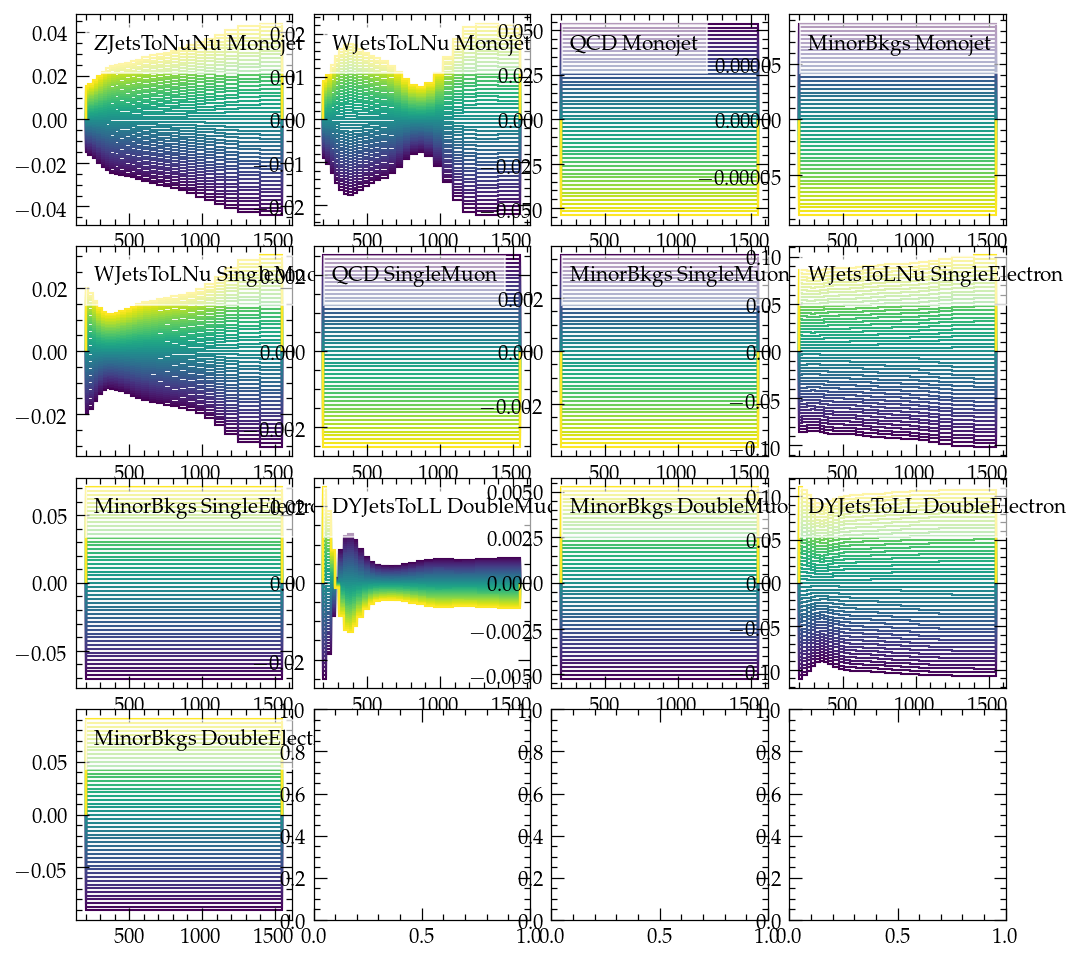

In [46]:
region_procs = [
    ("Monojet", "ZJetsToNuNu"),
    ("Monojet", "WJetsToLNu"),
    ("Monojet", "QCD"),
    ("Monojet", "MinorBkgs"),
    ("SingleMuon", "WJetsToLNu"),
    ("SingleMuon", "QCD"),
    ("SingleMuon", "MinorBkgs"),
    ("SingleElectron", "WJetsToLNu"),
    ("SingleElectron", "MinorBkgs"),
    ("DoubleMuon", "DYJetsToLL"),
    ("DoubleMuon", "MinorBkgs"),
    ("DoubleElectron", "DYJetsToLL"),
    ("DoubleElectron", "MinorBkgs"),
]
nuisance = "jesTotal"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(region_procs)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, (region, process) in enumerate(region_procs):
    model.set_parameters(mod_params)
    nom = model.prediction(region).loc[(process)].values
    
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[nuisance] = theta
        model.set_parameters(tparams)
        pred = model.prediction(region).loc[(process)].values
    
        row = idx//4
        col = idx%4
        if len(region_procs)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=process+" "+region)
